<a href="https://colab.research.google.com/github/REFENTSE-MOTLGELWA/classification-predict-streamlit-template/blob/master/Kaggle_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# <font color=blue>Kaggle Classification Challenge

___

## <font color=blue>Problem statement and Overview 

The purpose of this notebook is to show our workings as Team 5 for the Kaggle in-class challenge on perfoming sentiment analysis on tweets, particularly **predicting or classifying how a particular Twitter user feels about Climate Change based on their body of messgae/tweet**.<br>

##### <font color=blue>Team 5 members:<br>
- Evans Marema
- Vinita Maharaj
- Gugu Mtonjeni
- Refentse Motlogelwa
- Sandile Dladla
- Sandile Mkize

For this challenge we were provided with two datasets(for taining and testing our models) and a sample submission 

- test.csv ---------------------------- Dataset to be used for predictions which will be accessed on Kaggle model
- train.csv --------------------------- Dataset to be use for training model
- sample_submission.csv ------ An Example of a submission file

___

In [ ]:
# Import comet_ml for versioning
from comet_ml import Experiment

experiment = Experiment(api_key="toXXRULujXVmmXBW2zMcncxEI",
                        project_name="general", workspace="shyken")

COMET INFO: Experiment is live on comet.ml https://www.comet.ml/shyken/general/49683782d19b4d558e999aa6c5590bfd



### <font color=blue>Library imports

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import spacy
import re
import emoji

In [ ]:
# For printing option and text color
class color:
    PURPLE = '\033[95m'
    CYAN = '\033[96m'
    DARKCYAN = '\033[36m'
    BLUE = '\033[94m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    END = '\033[0m'

In [4]:
df_sub = pd.read_csv('sample_submission.csv')
df_test = pd.read_csv('test.csv')
test_df = df_test.set_index('tweetid')
df_train = pd.read_csv('train.csv')
train_df = df_train.set_index('tweetid')

In [ ]:
test_df.head()

,message
tweetid,
169760,Europe will now be looking to China to make su...
35326,Combine this with the polling of staffers re c...
224985,"The scary, unimpeachable evidence that climate..."
476263,@Karoli @morgfair @OsborneInk @dailykos \nPuti...
872928,RT @FakeWillMoore: 'Female orgasms cause globa...


In [ ]:
test_df.shape

(10546, 1)

In [ ]:
train_df.head()

,sentiment,message
tweetid,,
625221,1,PolySciMajor EPA chief doesn't think carbon di...
126103,1,It's not like we lack evidence of anthropogeni...
698562,2,RT @RawStory: Researchers say we have three ye...
573736,1,#TodayinMaker# WIRED : 2016 was a pivotal year...
466954,1,"RT @SoyNovioDeTodas: It's 2016, and a racist, ..."


In [ ]:
train_df.shape

(15819, 2)

## <font color=blue> Exploditory Data Analysis 

In [ ]:
print(f'Missing values in train dataset:\n{train_df.isna().sum()}\n')
print(f'Missing values in test dataset:\n{test_df.isna().sum()}')

Missing values in train dataset:
sentiment    0
message      0
dtype: int64

Missing values in test dataset:
message    0
dtype: int64


In [ ]:
# Checking for Empty messages in both train and test datasets

blanks_test = []
for tID,msg in test_df.itertuples():
    if msg.isspace == True:
        blanks_test.append(tID)

blanks_train = []
for tID,sent,msg in train_df.itertuples():
    if msg.isspace == True:
        blanks_test.append(tID)

In [ ]:
print(f'No. of empty messages in train: {len(blanks_train)}\n')
print(f'No. of empty messages in test: {len(blanks_test)}')

No. of empty messages in train: 0

No. of empty messages in test: 0


**Both the train and test datasets do not have nulls or empty strings** 

___

Different `sentiment` classes types and their corrisponding descriptions

<img src="https://github.com/REFENTSE-MOTLGELWA/classification-predict-streamlit-template/blob/master/class_description.png?raw=1">

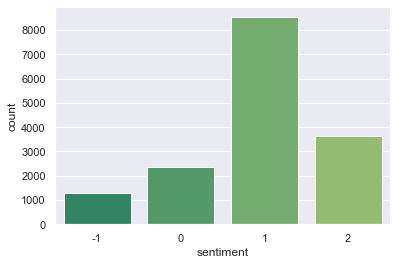

In [ ]:
# Count of classes in sentiment 

sns.set(style="darkgrid",palette='summer')
ax = sns.countplot(x='sentiment', data=train_df)

In [ ]:
print(color.BOLD +'Percentage of a particular `Class` in the train dataset\n'+ color.END)
print(f'Class 2 ~ News \n{round((df_train.sentiment.value_counts()[2]/len(df_train))*100,2)} %\n')
print(f'Class 1 ~ Pro \n{round((df_train.sentiment.value_counts()[1]/len(df_train))*100,2)} %\n')
print(f'Class 0 ~ Neutral \n{round((df_train.sentiment.value_counts()[0]/len(df_train))*100,2)} %\n')
print(f'Class -1 ~ Anti \n{round((df_train.sentiment.value_counts()[-1]/len(df_train))*100,2)} %')

Percentage of a particular `Class` in the train dataset

Class 2 ~ News 
23.01 %

Class 1 ~ Pro 
53.92 %

Class 0 ~ Neutral 
14.87 %

Class -1 ~ Anti 
8.19 %


**Checking length of tweets per class**

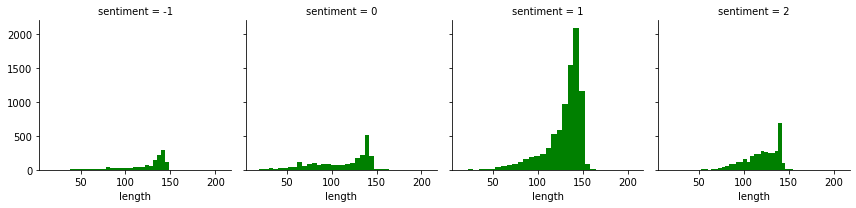

In [7]:
df_train['length'] = df_train['message'].apply(len)
graph = sns.FacetGrid(data=df_train, col = 'sentiment', col_wrap=4)
graph.map(plt.hist, 'length', bins = 30, color = 'g')

**Checking for duplicates and removing them**

In [ ]:
# checking for an
def duplicate_remover(df,column_name):
    copy = df.copy()
    cn = column_name
    i = 0
    for tweet in copy[cn]:
        
        if i in copy.index:
            
            if (copy[cn]==copy[cn][i]).sum() > 1:
                dup_index = list(copy[copy[cn]==copy[cn][i]].index)
                dup_index.pop(0)
                copy.drop(axis=0,index=dup_index,inplace=True)
                copy.reset_index(drop=True)
            i=i+1
        else:
            i=i+1
    return copy.reset_index(drop=True)

In [ ]:
train = duplicate_remover(train_df,'message')
test = test_df.copy()

In [ ]:
print(train.shape)
print(test.shape)

(15125, 2)
(10546, 1)


In [ ]:
train_diff = train_df.sentiment.value_counts() - train.sentiment.value_counts()
train_diff

 1    649
 2     18
 0     23
-1      4
Name: sentiment, dtype: int64

**The following functions are both to feature selection and extract useful information that will be used for insights**


Feature's like `url's`,  `@mentions`,  `hashtags` and `emojis` will be analised further to gain insight

In [ ]:
# Finds URL's in a string
def find_url(string): 
    text = re.findall('http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',string)
    return "".join(text)

In [ ]:
train['url'] = train.message.apply(lambda x:find_url(x))

test['url']= test.message.apply(lambda x:find_url(x))

In [ ]:
# Finds and removes url in tweets boby 
train['message']=train['message'].apply(lambda x: re.sub(
    pattern='http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
    repl='',
    string=x))

test['message']=test['message'].apply(lambda x: re.sub(
    pattern='http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+',
    repl='',
    string=x))

In [ ]:
# Corrects/replaces contractions with full words

def correct_contraction(tweet):
    tweet = re.sub(r"he's", "he is", tweet)
    tweet = re.sub(r"there's", "there is", tweet)
    tweet = re.sub(r"We're", "We are", tweet)
    tweet = re.sub(r"That's", "That is", tweet)
    tweet = re.sub(r"won't", "will not", tweet)
    tweet = re.sub(r"they're", "they are", tweet)
    tweet = re.sub(r"Can't", "Cannot", tweet)
    tweet = re.sub(r"wasn't", "was not", tweet)
    tweet = re.sub(r"aren't", "are not", tweet)
    tweet = re.sub(r"isn't", "is not", tweet)
    tweet = re.sub(r"What's", "What is", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"should've", "should have", tweet)
    tweet = re.sub(r"where's", "where is", tweet)
    tweet = re.sub(r"we'd", "we would", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"weren't", "were not", tweet)
    tweet = re.sub(r"They're", "They are", tweet)
    tweet = re.sub(r"let's", "let us", tweet)
    tweet = re.sub(r"it's", "it is", tweet)
    tweet = re.sub(r"can't", "cannot", tweet)
    tweet = re.sub(r"don't", "do not", tweet)
    tweet = re.sub(r"you're", "you are", tweet)
    tweet = re.sub(r"i've", "I have", tweet)
    tweet = re.sub(r"that's", "that is", tweet)
    tweet = re.sub(r"i'll", "I will", tweet)
    tweet = re.sub(r"doesn't", "does not", tweet)
    tweet = re.sub(r"i'd", "I would", tweet)
    tweet = re.sub(r"didn't", "did not", tweet)
    tweet = re.sub(r"ain't", "am not", tweet)
    tweet = re.sub(r"you'll", "you will", tweet)
    tweet = re.sub(r"I've", "I have", tweet)
    tweet = re.sub(r"Don't", "do not", tweet)
    tweet = re.sub(r"I'll", "I will", tweet)
    tweet = re.sub(r"I'd", "I would", tweet)
    tweet = re.sub(r"Let's", "Let us", tweet)
    tweet = re.sub(r"you'd", "You would", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"Ain't", "am not", tweet)
    tweet = re.sub(r"Haven't", "Have not", tweet)
    tweet = re.sub(r"Could've", "Could have", tweet)
    tweet = re.sub(r"youve", "you have", tweet)
    tweet = re.sub(r"haven't", "have not", tweet)
    tweet = re.sub(r"hasn't", "has not", tweet)
    tweet = re.sub(r"There's", "There is", tweet)
    tweet = re.sub(r"He's", "He is", tweet)
    tweet = re.sub(r"It's", "It is", tweet)
    tweet = re.sub(r"You're", "You are", tweet)
    tweet = re.sub(r"I'M", "I am", tweet)
    tweet = re.sub(r"shouldn't", "should not", tweet)
    tweet = re.sub(r"wouldn't", "would not", tweet)
    tweet = re.sub(r"i'm", "I am", tweet)
    tweet = re.sub(r"I'm", "I am", tweet)
    tweet = re.sub(r"Isn't", "is not", tweet)
    tweet = re.sub(r"Here's", "Here is", tweet)
    tweet = re.sub(r"you've", "you have", tweet)
    tweet = re.sub(r"we're", "we are", tweet)
    tweet = re.sub(r"what's", "what is", tweet)
    tweet = re.sub(r"couldn't", "could not", tweet)
    tweet = re.sub(r"we've", "we have", tweet)
    tweet = re.sub(r"who's", "who is", tweet)
    tweet = re.sub(r"y'all", "you all", tweet)
    tweet = re.sub(r"would've", "would have", tweet)
    tweet = re.sub(r"it'll", "it will", tweet)
    tweet = re.sub(r"we'll", "we will", tweet)
    tweet = re.sub(r"We've", "We have", tweet)
    tweet = re.sub(r"he'll", "he will", tweet)
    tweet = re.sub(r"Y'all", "You all", tweet)
    tweet = re.sub(r"Weren't", "Were not", tweet)
    tweet = re.sub(r"Didn't", "Did not", tweet)
    tweet = re.sub(r"they'll", "they will", tweet)
    tweet = re.sub(r"they'd", "they would", tweet)
    tweet = re.sub(r"DON'T", "DO NOT", tweet)
    tweet = re.sub(r"they've", "they have", tweet)
    
    #correct some acronyms while we are at it
    tweet = re.sub(r"tnwx", "Tennessee Weather", tweet)
    tweet = re.sub(r"azwx", "Arizona Weather", tweet)  
    tweet = re.sub(r"alwx", "Alabama Weather", tweet)
    tweet = re.sub(r"wordpressdotcom", "wordpress", tweet)      
    tweet = re.sub(r"gawx", "Georgia Weather", tweet)  
    tweet = re.sub(r"scwx", "South Carolina Weather", tweet)  
    tweet = re.sub(r"cawx", "California Weather", tweet)
    tweet = re.sub(r"usNWSgov", "United States National Weather Service", tweet) 
    tweet = re.sub(r"MH370", "Malaysia Airlines Flight 370", tweet)
    tweet = re.sub(r"okwx", "Oklahoma City Weather", tweet)
    tweet = re.sub(r"arwx", "Arkansas Weather", tweet)  
    tweet = re.sub(r"lmao", "laughing my ass off", tweet)  
    tweet = re.sub(r"amirite", "am I right", tweet)
    
    #and some typos/abbreviations
    tweet = re.sub(r"w/e", "whatever", tweet)
    tweet = re.sub(r"w/", "with", tweet)
    tweet = re.sub(r"USAgov", "USA government", tweet)
    tweet = re.sub(r"recentlu", "recently", tweet)
    tweet = re.sub(r"Ph0tos", "Photos", tweet)
    tweet = re.sub(r"exp0sed", "exposed", tweet)
    tweet = re.sub(r"<3", "love", tweet)
    tweet = re.sub(r"amageddon", "armageddon", tweet)
    tweet = re.sub(r"Trfc", "Traffic", tweet)
    tweet = re.sub(r"WindStorm", "Wind Storm", tweet)
    tweet = re.sub(r"16yr", "16 year", tweet)
    tweet = re.sub(r"TRAUMATISED", "traumatized", tweet)
    
    #hashtags and usernames
    tweet = re.sub(r"IranDeal", "Iran Deal", tweet)
    tweet = re.sub(r"ArianaGrande", "Ariana Grande", tweet)
    tweet = re.sub(r"camilacabello97", "camila cabello", tweet) 
    tweet = re.sub(r"RondaRousey", "Ronda Rousey", tweet)     
    tweet = re.sub(r"MTVHottest", "MTV Hottest", tweet)
    tweet = re.sub(r"TrapMusic", "Trap Music", tweet)
    tweet = re.sub(r"ProphetMuhammad", "Prophet Muhammad", tweet)
    tweet = re.sub(r"PantherAttack", "Panther Attack", tweet)
    tweet = re.sub(r"StrategicPatience", "Strategic Patience", tweet)
    tweet = re.sub(r"socialnews", "social news", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ClaytonBryant", "Clayton Bryant", tweet)
    tweet = re.sub(r"jimmyfallon", "jimmy fallon", tweet)
    tweet = re.sub(r"justinbieber", "justin bieber", tweet)  
    tweet = re.sub(r"UTC2015", "UTC 2015", tweet)
    tweet = re.sub(r"Time2015", "Time 2015", tweet)
    tweet = re.sub(r"djicemoon", "dj icemoon", tweet)
    tweet = re.sub(r"LivingSafely", "Living Safely", tweet)
    tweet = re.sub(r"FIFA16", "Fifa 2016", tweet)
    tweet = re.sub(r"thisiswhywecanthavenicethings", "this is why we cannot have nice things", tweet)
    tweet = re.sub(r"bbcnews", "bbc news", tweet)
    tweet = re.sub(r"UndergroundRailraod", "Underground Railraod", tweet)
    tweet = re.sub(r"c4news", "c4 news", tweet)
    tweet = re.sub(r"OBLITERATION", "obliteration", tweet)
    tweet = re.sub(r"MUDSLIDE", "mudslide", tweet)
    tweet = re.sub(r"NoSurrender", "No Surrender", tweet)
    tweet = re.sub(r"NotExplained", "Not Explained", tweet)
    tweet = re.sub(r"greatbritishbakeoff", "great british bake off", tweet)
    tweet = re.sub(r"LondonFire", "London Fire", tweet)
    tweet = re.sub(r"KOTAWeather", "KOTA Weather", tweet)
    tweet = re.sub(r"LuchaUnderground", "Lucha Underground", tweet)
    tweet = re.sub(r"KOIN6News", "KOIN 6 News", tweet)
    tweet = re.sub(r"LiveOnK2", "Live On K2", tweet)
    tweet = re.sub(r"9NewsGoldCoast", "9 News Gold Coast", tweet)
    tweet = re.sub(r"nikeplus", "nike plus", tweet)
    tweet = re.sub(r"david_cameron", "David Cameron", tweet)
    tweet = re.sub(r"peterjukes", "Peter Jukes", tweet)
    tweet = re.sub(r"MikeParrActor", "Michael Parr", tweet)
    tweet = re.sub(r"4PlayThursdays", "Foreplay Thursdays", tweet)
    tweet = re.sub(r"TGF2015", "Tontitown Grape Festival", tweet)
    tweet = re.sub(r"realmandyrain", "Mandy Rain", tweet)
    tweet = re.sub(r"GraysonDolan", "Grayson Dolan", tweet)
    tweet = re.sub(r"ApolloBrown", "Apollo Brown", tweet)
    tweet = re.sub(r"saddlebrooke", "Saddlebrooke", tweet)
    tweet = re.sub(r"TontitownGrape", "Tontitown Grape", tweet)
    tweet = re.sub(r"AbbsWinston", "Abbs Winston", tweet)
    tweet = re.sub(r"ShaunKing", "Shaun King", tweet)
    tweet = re.sub(r"MeekMill", "Meek Mill", tweet)
    tweet = re.sub(r"TornadoGiveaway", "Tornado Giveaway", tweet)
    tweet = re.sub(r"GRupdates", "GR updates", tweet)
    tweet = re.sub(r"SouthDowns", "South Downs", tweet)
    tweet = re.sub(r"braininjury", "brain injury", tweet)
    tweet = re.sub(r"auspol", "Australian politics", tweet)
    tweet = re.sub(r"PlannedParenthood", "Planned Parenthood", tweet)
    tweet = re.sub(r"calgaryweather", "Calgary Weather", tweet)
    tweet = re.sub(r"weallheartonedirection", "we all heart one direction", tweet)
    tweet = re.sub(r"edsheeran", "Ed Sheeran", tweet)
    tweet = re.sub(r"TrueHeroes", "True Heroes", tweet)
    tweet = re.sub(r"ComplexMag", "Complex Magazine", tweet)
    tweet = re.sub(r"TheAdvocateMag", "The Advocate Magazine", tweet)
    tweet = re.sub(r"CityofCalgary", "City of Calgary", tweet)
    tweet = re.sub(r"EbolaOutbreak", "Ebola Outbreak", tweet)
    tweet = re.sub(r"SummerFate", "Summer Fate", tweet)
    tweet = re.sub(r"RAmag", "Royal Academy Magazine", tweet)
    tweet = re.sub(r"offers2go", "offers to go", tweet)
    tweet = re.sub(r"ModiMinistry", "Modi Ministry", tweet)
    tweet = re.sub(r"TAXIWAYS", "taxi ways", tweet)
    tweet = re.sub(r"Calum5SOS", "Calum Hood", tweet)
    tweet = re.sub(r"JamesMelville", "James Melville", tweet)
    tweet = re.sub(r"JamaicaObserver", "Jamaica Observer", tweet)
    tweet = re.sub(r"TweetLikeItsSeptember11th2001", "Tweet like it is september 11th 2001", tweet)
    tweet = re.sub(r"cbplawyers", "cbp lawyers", tweet)
    tweet = re.sub(r"fewmoretweets", "few more tweets", tweet)
    tweet = re.sub(r"BlackLivesMatter", "Black Lives Matter", tweet)
    tweet = re.sub(r"NASAHurricane", "NASA Hurricane", tweet)
    tweet = re.sub(r"onlinecommunities", "online communities", tweet)
    tweet = re.sub(r"humanconsumption", "human consumption", tweet)
    tweet = re.sub(r"Typhoon-Devastated", "Typhoon Devastated", tweet)
    tweet = re.sub(r"Meat-Loving", "Meat Loving", tweet)
    tweet = re.sub(r"facialabuse", "facial abuse", tweet)
    tweet = re.sub(r"LakeCounty", "Lake County", tweet)
    tweet = re.sub(r"BeingAuthor", "Being Author", tweet)
    tweet = re.sub(r"withheavenly", "with heavenly", tweet)
    tweet = re.sub(r"thankU", "thank you", tweet)
    tweet = re.sub(r"iTunesMusic", "iTunes Music", tweet)
    tweet = re.sub(r"OffensiveContent", "Offensive Content", tweet)
    tweet = re.sub(r"WorstSummerJob", "Worst Summer Job", tweet)
    tweet = re.sub(r"HarryBeCareful", "Harry Be Careful", tweet)
    tweet = re.sub(r"NASASolarSystem", "NASA Solar System", tweet)
    tweet = re.sub(r"animalrescue", "animal rescue", tweet)
    tweet = re.sub(r"KurtSchlichter", "Kurt Schlichter", tweet)
    tweet = re.sub(r"aRmageddon", "armageddon", tweet)
    tweet = re.sub(r"Throwingknifes", "Throwing knives", tweet)
    tweet = re.sub(r"GodsLove", "God's Love", tweet)
    tweet = re.sub(r"bookboost", "book boost", tweet)
    tweet = re.sub(r"ibooklove", "I book love", tweet)
    tweet = re.sub(r"NestleIndia", "Nestle India", tweet)
    tweet = re.sub(r"realDonaldTrump", "Donald Trump", tweet)
    tweet = re.sub(r"DavidVonderhaar", "David Vonderhaar", tweet)
    tweet = re.sub(r"CecilTheLion", "Cecil The Lion", tweet)
    tweet = re.sub(r"weathernetwork", "weather network", tweet)
    tweet = re.sub(r"withBioterrorism&use", "with Bioterrorism & use", tweet)
    tweet = re.sub(r"Hostage&2", "Hostage & 2", tweet)
    tweet = re.sub(r"GOPDebate", "GOP Debate", tweet)
    tweet = re.sub(r"RickPerry", "Rick Perry", tweet)
    tweet = re.sub(r"frontpage", "front page", tweet)
    tweet = re.sub(r"NewsInTweets", "News In Tweets", tweet)
    tweet = re.sub(r"ViralSpell", "Viral Spell", tweet)
    tweet = re.sub(r"til_now", "until now", tweet)
    tweet = re.sub(r"volcanoinRussia", "volcano in Russia", tweet)
    tweet = re.sub(r"ZippedNews", "Zipped News", tweet)
    tweet = re.sub(r"MicheleBachman", "Michele Bachman", tweet)
    tweet = re.sub(r"53inch", "53 inch", tweet)
    tweet = re.sub(r"KerrickTrial", "Kerrick Trial", tweet)
    tweet = re.sub(r"abstorm", "Alberta Storm", tweet)
    tweet = re.sub(r"Beyhive", "Beyonce hive", tweet)
    tweet = re.sub(r"IDFire", "Idaho Fire", tweet)
    tweet = re.sub(r"DETECTADO", "Detected", tweet)
    tweet = re.sub(r"RockyFire", "Rocky Fire", tweet)
    tweet = re.sub(r"Listen/Buy", "Listen / Buy", tweet)
    tweet = re.sub(r"yycstorm", "Calgary Storm", tweet)
    tweet = re.sub(r"IDPs:", "Internally Displaced People :", tweet)
    tweet = re.sub(r"ArtistsUnited", "Artists United", tweet)
    tweet = re.sub(r"ENGvAUS", "England vs Australia", tweet)
    tweet = re.sub(r"ScottWalker", "Scott Walker", tweet)

    
    return tweet

In [ ]:
train['message']=train['message'].apply(lambda x: correct_contraction(x))

test['message']=test['message'].apply(lambda x: correct_contraction(x))

In [ ]:
# Finds @ mentions in tweets
def find_at(text):
    line=re.findall(r'(?<=@)\w+',text)
    return " ".join(line)

In [ ]:
train['mention']=train['message'].apply(lambda x: find_at(x))
train['message']=train['message'].apply(lambda x: re.sub(r'(?<=@)\w+','',x))

test['mention']=test['message'].apply(lambda x: find_at(x))
test['message']=test['message'].apply(lambda x: re.sub(r'(?<=@)\w+','',x))

In [ ]:
# Finds hashtags in tweet(#)
def find_hash(text):
    line=re.findall(r'(?<=#)\w+',text)
    return " ".join(line)

In [ ]:
train['hashtags']=train['message'].apply(lambda x: find_hash(x))
train['message']=train['message'].apply(lambda x: re.sub(r'(?<=#)\w+','',x))

test['hashtags']=test['message'].apply(lambda x: find_hash(x))
test['message']=test['message'].apply(lambda x: re.sub(r'(?<=#)\w+','',x))

In [ ]:
# Finds emoji's in a tweet
def find_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    emo = re.findall(emoji_pattern, text)
    return ''.join(emo)

In [ ]:
train['emoji']=train['message'].apply(lambda x: find_emoji(x))

test['emoji']=test['message'].apply(lambda x: find_emoji(x))

In [ ]:
train['message']=train['message'].apply(lambda x: re.sub(find_emoji(x),'',x))

test['message']=test['message'].apply(lambda x: re.sub(find_emoji(x),'',x))

In [ ]:
train.head()

,sentiment,message,url,mention,hashtags,emoji
0,1,PolySciMajor EPA chief does not think carbon d...,https://t.co/yeLvcEFXkC,mashable,,
1,1,It is not like we lack evidence of anthropogen...,,,,
2,2,RT @: Researchers say we have three years to a...,https://t.co/WdT0KdUr2fhttps://t.co/Z0ANPT,RawStory,,
3,1,## WIRED : 2016 was a pivotal year in the war ...,https://t.co/44wOTxTLcD,,TodayinMaker,
4,1,"RT @: It is 2016, and a racist, sexist, climat...",,SoyNovioDeTodas,ElectionNight,


In [ ]:
test.head()

,message,url,mention,hashtags,emoji
tweetid,,,,,
169760,Europe will now be looking to China to make su...,https://t.co/O7T8rCgwDq,,,
35326,Combine this with the polling of staffers re c...,https://t.co/ifrm7eexpj,,,
224985,"The scary, unimpeachable evidence that climate...",https://t.co/yAedqcV9Ki,ZEROCO2_,itstimetochange climatechange,
476263,@ @ @ @ \nPutin got to you too Jill ! \nTrump ...,,Karoli morgfair OsborneInk dailykos,,
872928,RT @: 'Female orgasms cause global warming!'\n...,,FakeWillMoore,,


From this we observe that the classses are unbalnced and we also observe that the Pro Class has the highest count and is about 2x the second highest class. We expect that this this class will be the most correctly classified out of all other classes.

___

## <font color=blue>Model Building

### <font color=blue>Library Imports for model building

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.neighbors import KNeighborsClassifier
import pickle

In [ ]:
X = train['message']
y = train.sentiment.values

In [ ]:
# Splitting train dataset into train subset(for training model) and validation subset(for model evaluation)
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.25,random_state=0)

In [ ]:
vectorizer = TfidfVectorizer()
X_vec = vectorizer.fit_transform(X_train)

### <font color=blue>Linear Support Vector Classifier

#### <font color=blue>Training LinearSVC

In [ ]:
# A Pipeline that first imploys tokenazation and vectorization and then trains model using Linear-SVC using train data.
cl_pipe = Pipeline([('vectorizer', TfidfVectorizer()),
                     ('linearS', LinearSVC()),])


In [ ]:
# Fitting/training model
cl_pipe.fit(X_train, y_train) 

#### <font color=blue>Accessing LinearSVC Acurracy

In [ ]:
# Predicting test subset of validation data
y_pred = cl_pipe.predict(X_test)

In [ ]:
# LinearSVC confusion matrix
LSVC_confusion = pd.DataFrame(confusion_matrix(y_test,y_pred),
                  index=['Anti','Neutral','Pro','News'],
                  columns=['Anti','Neutral','Pro','News'])

LSVC_confusion

,Anti,Neutral,Pro,News
Anti,130,48,129,17
Neutral,36,221,257,37
Pro,27,109,1687,198
News,7,26,179,674


In [ ]:
# Classification Report matrix 
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

          -1       0.65      0.40      0.50       324
           0       0.55      0.40      0.46       551
           1       0.75      0.83      0.79      2021
           2       0.73      0.76      0.74       886

    accuracy                           0.72      3782
   macro avg       0.67      0.60      0.62      3782
weighted avg       0.71      0.72      0.71      3782



The important metric to note is the f1-score (macro avg) since its the
metric used on kaggle for scoring. The score obtained on the notebook will
not be the same as the one to be obtained on kaggle.The score on the notebook is helpful on gauging 
your margins and comparing different models on the notebook.

#### <font color=blue>Predictions on test dataset  using LinearSVC

In [ ]:
y_pred_test = cl_pipe.predict(test.message)

In [ ]:
y_pred_test

array([1, 1, 1, ..., 2, 0, 1], dtype=int64)

In [ ]:
# Predictions in submission kaggle format
linearSVC_submission1 = pd.DataFrame({'tweetid': test.index, 
                           'sentiment': y_pred_test})

In [ ]:
linearSVC_submission1

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,0
4,872928,1
...,...,...
10541,895714,0
10542,875167,1
10543,78329,2
10544,867455,0


In [ ]:
# Saving to .csv file
linearSVC_submission1.to_csv('LSVC_01.csv',index = False)

#### <font color=blue>Save Model

In [ ]:
import pickle

# Saving the entire pipeline.
# Saving the pipeline in the same name as the submission file helps keep track of everything.

model_save_path = "LSVC_01.pkl"
with open(model_save_path,'wb') as file:
    pickle.dump(cl_pipe,file)

### <font color=blue>K-Nearest Neighbors Classifier

#### <font color=blue>Training KNN Classifier

In [ ]:
# Instantiate KNN model
KNN = KNeighborsClassifier(n_neighbors=10)

In [ ]:
# KNN pipeline
KNN_pipe = Pipeline([('vectorizer', TfidfVectorizer()),('KNN',KNN)])

In [ ]:
# Fitting/Training KNN model
KNN_pipe.fit(X_train,y_train.ravel())

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('KNN', KNeighborsClassifier(n_neighbors=10))])

#### <font color=blue>Accessing KNN accuracy

In [ ]:
# Predicting validation subset
y_pred_KNN = KNN_pipe.predict(X_test)

In [ ]:
# KNN confusion matrix
KNN_confusion = pd.DataFrame(confusion_matrix(y_test,y_pred_KNN),
                  index=['Anti','Neutral','Pro','News'],
                  columns=['Anti','Neutral','Pro','News'])

KNN_confusion

,Anti,Neutral,Pro,News
Anti,98,40,154,32
Neutral,23,197,296,35
Pro,31,121,1661,208
News,10,32,290,554


In [ ]:
# Classification report matrix
print(classification_report(y_test,y_pred_KNN))

              precision    recall  f1-score   support

          -1       0.60      0.30      0.40       324
           0       0.51      0.36      0.42       551
           1       0.69      0.82      0.75      2021
           2       0.67      0.63      0.65       886

    accuracy                           0.66      3782
   macro avg       0.62      0.53      0.55      3782
weighted avg       0.65      0.66      0.65      3782



#### <font color=blue>Predictions on test dataset using KNN

In [ ]:
y_KNN = KNN_pipe.predict(test.message)

In [ ]:
y_KNN

array([1, 1, 1, ..., 2, 0, 1], dtype=int64)

In [ ]:
# Predictions in submission kaggle format
KNN_submission1 = pd.DataFrame({'tweetid': test.index, 
                           'sentiment': y_KNN})

KNN_submission1

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,0
...,...,...
10541,895714,0
10542,875167,1
10543,78329,2
10544,867455,0


In [ ]:
# Saving to .csv file
KNN_submission1.to_csv('KNN_01.csv',index = False)

#### <font color=blue>Save Model

In [ ]:
model_save_path = 'KNN_01.pkl'
with open(model_save_path,'wb') as file:
    pickle.dump(KNN_pipe,file)

### <font color=blue>Random forest Classifier

#### <font color=blue>Training Random forest Classifier

In [ ]:
# Instantiating Random forest Classifier
RFC = RandomForestClassifier(n_estimators=100)

In [ ]:
# Random forest pipeline
RFC_pipe = Pipeline([('vectorizer', TfidfVectorizer()),
                     ('RFC',RFC)])

In [ ]:
# Fitting/Training model
RFC_pipe.fit(X_train,y_train.ravel())

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('RFC', RandomForestClassifier())])

#### <font color=blue>Accessing RFC accuracy

In [ ]:
# Predicting validation subset
y_pred_RFC = RFC_pipe.predict(X_test)

In [ ]:
# RFC Confusion matrix
RFC_confusion = pd.DataFrame(confusion_matrix(y_test,y_pred_RFC),
                  index=['Anti','Neutral','Pro','News'],
                  columns=['Anti','Neutral','Pro','News'])

In [ ]:
# Classification report matrix
print(classification_report(y_test,y_pred_RFC))

              precision    recall  f1-score   support

          -1       0.94      0.15      0.26       324
           0       0.64      0.26      0.37       551
           1       0.67      0.91      0.77      2021
           2       0.79      0.68      0.73       886

    accuracy                           0.70      3782
   macro avg       0.76      0.50      0.53      3782
weighted avg       0.72      0.70      0.66      3782



#### <font color=blue>Hyperparameter Tunning for RFC

In [ ]:
# Selecting Parameter to tune

n_estimators = [int(x) for x in np.linspace(start=200, stop=2000, num=10)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num=11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
random_state = list(range(0,43))

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap,
               'random_state':random_state}

In [ ]:
# Re-instantiate Random Classifier for tunning
rfc = RandomForestClassifier()

In [ ]:
# Instantiate Random Search
RFC_Random = RandomizedSearchCV(estimator=rfc, 
                               param_distributions=random_grid,
                               n_iter=5, cv=5, verbose=2, random_state=42)

Before we do Random Search on the RFC model we need to vectorize our Predictor variable since we are doing a randomized grid search on the RFC model and not on it's pipeline, although it is possible to do a randomised grid search on the pipeline.

The reason for it takes this particuler Random Search takes so much time is the number of parameters we are tunning and also it runs `n_iter` by `cv` models. Hyperparameter tuning for some other models might much less time to run.

In [ ]:
vectorizer = TfidfVectorizer()
X_vec = vectorizer.fit_transform(X_train)

In [ ]:
# Fitting Random Search on train subset
RFC_Random.fit(X_vec,y_train.ravel())

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] random_state=10, n_estimators=1400, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=False 
[CV]  random_state=10, n_estimators=1400, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=False, total= 3.4min
[CV] random_state=10, n_estimators=1400, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=False 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.4min remaining:    0.0s


[CV]  random_state=10, n_estimators=1400, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=False, total= 3.3min
[CV] random_state=10, n_estimators=1400, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=False 
[CV]  random_state=10, n_estimators=1400, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=False, total= 3.3min
[CV] random_state=10, n_estimators=1400, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=False 
[CV]  random_state=10, n_estimators=1400, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=False, total= 3.3min
[CV] random_state=10, n_estimators=1400, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=False 
[CV]  random_state=10, n_estimators=1400, min_samples_split=5, min_samples_leaf=2, max_features=sqrt, max_depth=40, bootstrap=False, total= 3.3min
[CV] random_stat

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed: 98.1min finished


RandomizedSearchCV(cv=5, error_score='raise-deprecating',
                   estimator=RandomForestClassifier(bootstrap=True,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features='auto',
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    n_estimators='warn',
                                                    n_jobs=None

In [ ]:
# Retrieving parameters for the RFC model that performed best
RFC_Random.best_params_

{'random_state': 8,
 'n_estimators': 1800,
 'min_samples_split': 2,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 60,
 'bootstrap': False}

In [ ]:
# Re-instiate RFC with best parameters
rfc_boosted = RandomForestClassifier(random_state=8,
                                     n_estimators=1800,
                                     min_samples_split=2,
                                     min_samples_leaf=1,
                                     max_features='auto',
                                     max_depth=60,
                                     bootstrap=False)

In [ ]:
# Pipeline of RFC model with best parameters
boosted_pipe = Pipeline([('vectorizer', TfidfVectorizer()),('RFC',rfc_boosted)])

In [ ]:
# Fitting/Training model
boosted_pipe.fit(X_train,y_train.ravel())

Pipeline(steps=[('vectorizer', TfidfVectorizer()),
                ('RFC',
                 RandomForestClassifier(bootstrap=False, max_depth=60,
                                        n_estimators=1800, random_state=8))])

In [ ]:
# Predicting validation subset
y_pred_boost = boosted_pipe.predict(X_test)

In [ ]:
# RFC random search confusion matrix
RFC_RS_confusion = pd.DataFrame(confusion_matrix(y_test,y_pred_boost),
                  index=['Anti','Neutral','Pro','News'],
                  columns=['Anti','Neutral','Pro','News'])
RFC_RS_confusion

,Anti,Neutral,Pro,News
Anti,46,15,256,7
Neutral,1,98,439,13
Pro,1,14,1901,105
News,0,2,319,565


In [ ]:
# Classification report matrix
print(classification_report(y_test,y_pred_boost))

              precision    recall  f1-score   support

          -1       0.96      0.14      0.25       324
           0       0.76      0.18      0.29       551
           1       0.65      0.94      0.77      2021
           2       0.82      0.64      0.72       886

    accuracy                           0.69      3782
   macro avg       0.80      0.47      0.51      3782
weighted avg       0.73      0.69      0.64      3782



#### <font color=blue>Predictions on test dataset  using RFC_RS

In [ ]:
y_boost = boosted_pipe.predict(test.message)

In [ ]:
y_boost

array([1, 1, 1, ..., 1, 0, 1], dtype=int64)

In [ ]:
# Predictions in submission kaggle format
RFC_RS_submission1 = pd.DataFrame({'tweetid': test.index, 
                           'sentiment': y_boost})

RFC_RS_submission1 

,tweetid,sentiment
0,169760,1
1,35326,1
2,224985,1
3,476263,1
4,872928,0
...,...,...
10541,895714,1
10542,875167,1
10543,78329,1
10544,867455,0


In [ ]:
# Saving to .csv file
RFC_RS_submission1.to_csv('RandomForest_boosted_01.csv',index=False)

#### <font color=blue>Save Model

In [ ]:
model_save_path = 'RandomForest_boosted_01.pkl'
with open(model_save_path,'wb') as file:
    pickle.dump(boosted_pipe,file)

### <font color=blue>End Experiment

In [ ]:
experiment.end()

experiment.display()

COMET INFO: ---------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.ml/shyken/general/49683782d19b4d558e999aa6c5590bfd
COMET INFO:   Parameters [count]:
COMET INFO:     KNN_algorithm                : auto
COMET INFO:     KNN_leaf_size                : 30
COMET INFO:     KNN_metric                   : minkowski
COMET INFO:     KNN_metric_params            : 1
COMET INFO:     KNN_n_jobs                   : 1
COMET INFO:     KNN_n_neighbors              : 10
COMET INFO:     KNN_p                        : 2
COMET INFO:     KNN_weights                  : uniform
COMET INFO:     RFC_bootstrap [2]            : 2
COMET INFO:     RFC_ccp_alpha                : 1
COMET INFO:     RFC_class_weight             : 1
COMET INFO:     RFC_criterion                : gini
COMET INFO:     RFC_max_depth [2]            : 60
COMET INFO:    